## Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import os, random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Input, Flatten, Rescaling , Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score


In [12]:
DIR_PATH = r'D:\Programming\Machine Learning\Datasets\Image classification datasets\Traffic sign dataset'

In [13]:
os.chdir(DIR_PATH)
os.getcwd()

'D:\\Programming\\Machine Learning\\Datasets\\Image classification datasets\\Traffic sign dataset'

## Import dataset

In [59]:
def load_data(img_dim, csv_file_path = 'Train.csv'):

    images = []
    classes = []

    train_csv = pd.read_csv(csv_file_path)
    
    for row in train_csv.itertuples():
        class_id = int(row[-2])
        img_path = row[-1]
        
        if 'Test' in csv_file_path:
            img_path = img_path.replace('/', f"/{class_id}/")
        
        
        images.append(img_to_array(load_img(img_path, target_size = (img_dim, img_dim))))
        classes.append(class_id)
        
    return np.array(images), np.array(classes)
        


In [31]:
labels = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [17]:
images, classes = load_data(img_dim = 32)

In [18]:
images.shape, classes.shape

((39209, 32, 32, 3), (39209,))

### Class distribution

In [19]:
label_freq = dict()

for dir in os.listdir(os.path.join(os.getcwd(), 'Train')):
    label_freq[dir] = len(os.listdir(os.path.join(os.getcwd(), 'Train', dir)))

In [40]:
class_dist = pd.DataFrame(label_freq.items(), columns = ['label', 'count'])
class_dist['label'] = class_dist['label'].apply(int).map(labels)

In [41]:
class_dist.sort_values(by = 'count', ascending = False).style.background_gradient(cmap = 'Blues')

,label,count
12,Speed limit (50km/h),2250
1,Speed limit (30km/h),2220
5,Yield,2160
4,Priority road,2100
32,Keep right,2070
2,No passing veh over 3.5 tons,2010
34,Speed limit (70km/h),1980
38,Speed limit (80km/h),1860
18,Road work,1500
42,No passing,1470


## Train-Test split

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, classes, test_size = 0.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27446, 32, 32, 3), (11763, 32, 32, 3), (27446,), (11763,))

## Observing random images

In [20]:
def show_random_img(from_where = 'Train', n_images = 1):
    fig, axes = plt.subplots(ncols = n_images, nrows = 1, figsize=(3 * n_images, 3))
    for i in range(n_images):
        PATH = os.path.join(DIR_PATH, from_where)
        class_id = random.choice(os.listdir(PATH))
        IMG_PATH = random.choice(os.listdir(os.path.join(PATH, class_id)))
        IMG_PATH = os.path.join(PATH, class_id, IMG_PATH)
        img = mpimg.imread(IMG_PATH)

        try:
            axes[i].set_title(labels[int(class_id)])
            axes[i].imshow(img)
            axes[i].axis('off')
        except:
            axes.set_title(labels[int(class_id)])
            axes.imshow(img)
            axes.axis('off')
        

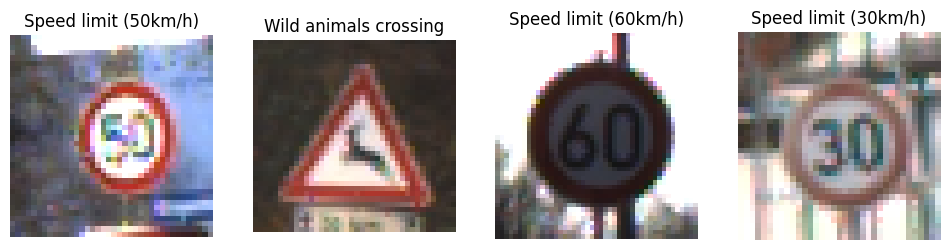

In [21]:
show_random_img(n_images=4)

## CNN Model

In [22]:
cnn_model = Sequential()

cnn_model.add(Input(shape = (32, 32, 3)))

cnn_model.add(Rescaling(1/255.))

cnn_model.add(Conv2D(filters = 32, strides = (1, 1), kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(Conv2D(filters = 64, strides = (1, 1), kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid', strides = (1, 1)))

cnn_model.add(Conv2D(filters = 32, strides = (1, 1), kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(Conv2D(filters = 32, strides = (1, 1), kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid', strides = (1, 1)))

cnn_model.add(Conv2D(filters = 32, strides = (1, 1), kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid', strides = (1, 1)))

cnn_model.add(Flatten())
cnn_model.add(Dropout(rate = 0.5))

cnn_model.add(Dense(units = 43, activation = 'softmax'))

In [23]:
cnn_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [24]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 23, 32)        9248      
                                                        

In [25]:
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    restore_best_weights = True,
    patience = 2,
    verbose = 2
)

In [26]:
cnn_history = cnn_model.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), epochs = 10, callbacks = [early_stop])

Epoch 1/10
858/858 [==============================] - 80s 92ms/step - loss: 0.5204 - accuracy: 0.8602 - val_loss: 0.1214 - val_accuracy: 0.9678
Epoch 2/10
858/858 [==============================] - 77s 90ms/step - loss: 0.0898 - accuracy: 0.9738 - val_loss: 0.0701 - val_accuracy: 0.9815
Epoch 3/10
858/858 [==============================] - 78s 91ms/step - loss: 0.0515 - accuracy: 0.9850 - val_loss: 0.0523 - val_accuracy: 0.9869
Epoch 4/10
858/858 [==============================] - 80s 94ms/step - loss: 0.0451 - accuracy: 0.9858 - val_loss: 0.0624 - val_accuracy: 0.9841
Epoch 5/10
858/858 [==============================] - 82s 96ms/step - loss: 0.0341 - accuracy: 0.9890 - val_loss: 0.0510 - val_accuracy: 0.9898
Epoch 6/10
858/858 [==============================] - 82s 95ms/step - loss: 0.0247 - accuracy: 0.9923 - val_loss: 0.0399 - val_accuracy: 0.9910
Epoch 7/10
858/858 [==============================] - 81s 95ms/step - loss: 0.0304 - accuracy: 0.9910 - val_loss: 0.0397 - val_accuracy:

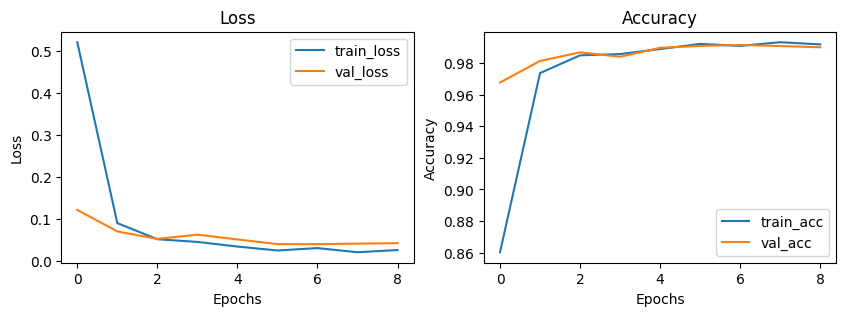

In [27]:
_, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 3))

ax1.plot(cnn_history.epoch, cnn_history.history['loss'], label = 'train_loss')
ax1.plot(cnn_history.epoch, cnn_history.history['val_loss'], label = 'val_loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.set_title('Accuracy')
ax2.plot(cnn_history.epoch, cnn_history.history['accuracy'], label = 'train_acc')
ax2.plot(cnn_history.epoch, cnn_history.history['val_accuracy'], label = 'val_acc')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend();

## Predict random images

In [29]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [74]:
def pred_random_img(model = cnn_model, n_images = 1, test_csv_path = 'Test.csv'):
    test_csv_path = os.path.join(DIR_PATH, test_csv_path)
    fig, axes = plt.subplots(ncols = n_images, nrows = 1, figsize=(3 * n_images, 3))
    test_csv = pd.read_csv(test_csv_path)

    for i in range(n_images):
        
        rand_row_ind = random.randint(0, len(test_csv))
        
        img_path = test_csv.loc[rand_row_ind, 'Path']
        class_id = test_csv.loc[rand_row_ind, 'ClassId']
        
        img_actual = load_img(os.path.join(DIR_PATH, img_path.replace('/', f"/{class_id}/")), target_size = (32, 32))
        img = tf.expand_dims((img_to_array(img_actual)), 0)
        pred_label = np.argmax(model.predict(img, verbose = 0))
        pred_class = labels[int(pred_label)]
        
        try:
            if(pred_class == labels[int(class_id)]):
                axes[i].set_title(f"Actual : {labels[int(class_id)]}\nPredicted : {pred_class}", color = 'green', fontsize = 8, fontweight = 'bold') 
            else:
                axes[i].set_title(f"Actual : {labels[int(class_id)]}\nPredicted : {pred_class}", color = 'red', fontsize = 8, fontweight = 'bold') 
            axes[i].imshow(img_actual)
            axes[i].axis('off')
        except:
            if(pred_class == labels[int(class_id)]):
                axes.set_title(f"Actual : {labels[int(class_id)]}\nPredicted : {pred_class}", color = 'green', fontsize = 8, fontweight = 'bold') 
            else:
                axes.set_title(f"Actual : {labels[int(class_id)]}\nPredicted : {pred_class}", color = 'red', fontsize = 8, fontweight = 'bold') 
            axes.imshow(img_actual)
            axes.axis('off')
        

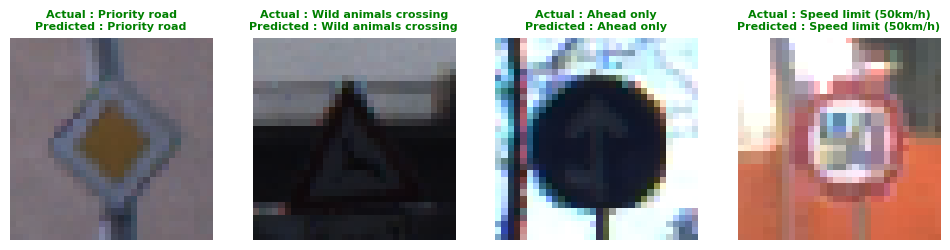

In [79]:
pred_random_img(n_images=4)

### Model performance evaluation

In [68]:
def model_report(model, X_true, y_true):
    y_pred = np.argmax(model.predict(X_true, verbose = 0), axis = 1)    
    
    return {
        'accuracy' : accuracy_score(y_true, y_pred),
        'recall' : recall_score(y_true, y_pred, average = 'weighted'),
        'precision' : precision_score(y_true, y_pred, average = 'weighted'),
        'f1' : f1_score(y_true, y_pred, average = 'weighted'),
        'y_pred' : y_pred
    }

In [59]:
model_report(model = cnn_model, X_true = X_test, y_true = y_test)

{'accuracy': 0.991583779648049,
 'recall': 0.991583779648049,
 'precision': 0.9916433315784978,
 'f1': 0.9915854392679597,
 'y_pred': array([17,  2, 25, ...,  8, 15,  8], dtype=int64)}

### Model performance on Test data

In [61]:
test_img, test_label = load_data(csv_file_path='Test.csv', img_dim=32)

In [69]:
model_report(model = cnn_model, X_true = test_img, y_true= test_label)

{'accuracy': 0.9644497228820269,
 'recall': 0.9644497228820269,
 'precision': 0.9662400505315482,
 'f1': 0.9640681439220744,
 'y_pred': array([16,  1, 38, ...,  5,  7, 10], dtype=int64)}

## Saving the model

In [63]:
os.chdir(r'D:\Programming\Machine Learning\ML Projects\Image Processing\Traffic sign recognition')

In [71]:
cnn_model.save('./traffic_sign_detector_2.keras')